Created: 2020.08.13

Modified: 2020.08.17

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

import random
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import gray2rgb

In [99]:
import sys
sys.path.append('functions')

%aimport functions00, functions01
from functions00 import *
from functions01 import *

import functions32 as f32
import functions50 as f50

In [4]:
mk_get_host_info()

**********************************************************************************************************************************
Settings:
	HOST:  mmiv-ml-titan
	PATH_ROOT_DATA:  /data-10tb/shared/skull/train-3d-iso
	PATH_GIT_HUB:  /data-10tb/marek/github_codes/skull-stripping-1/fastai
	PATH_2D: /data-10tb/shared/skull

3D DFs paths (_mk_3D):
	IXI_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/ixi_test_mk_3d.csv
	TEST_3D : /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv
	TRAIN_VAL_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/train_val_mk_3d.csv
	NFBS_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/nfbs_test_mk_3d.csv

Error files (pickle):
	ERROR_FILES: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/error_files
**********************************************************************

# 2D AXIAL - T1 biascorr - TEST_3D

#### Some global variables

In [5]:
SAVE_PTH_301_DATA = PATH_2D / 'pred' / '3.01' / 'test_3D'
SAVE_PTH_301_CSV = PATH_GIT_HUB / '5.0'

### Load df for training; get a few of the train rows

In [6]:
# LOADING TRAIN_VAL CSV FILE, REMOVE VAL PART AND MOST OF THE TRAIN PART
folder_path = PATH_2D /'axial-2d'

# csv file with path to images and masks
DATA_PATH_CSV_2D = 'bias_mask-test-val-axial-2d.csv'

df1 = pd.read_csv(folder_path/DATA_PATH_CSV_2D)
df1 = df1[df1['usage_txt'] == 'train'][:128*3]

# print(df1.shape)
print(df1.shape)
#df_train.head(1)

(384, 6)


In [7]:
# LOAD TEST_3D_CSV
test_name = PATH_2D /'axial-2d' / 'TEST_3D-bias-mask-axial-2d.csv'
df2 = pd.read_csv(test_name, index_col=None)
print(df2.shape)
#df_test.head(2)

(158226, 6)


In [8]:
# CONCATENATE TRAIN ADN TEST TABLES
df_test = pd.concat([df1, df2])
print(df_test.shape)
df_test.tail(2)

(158610, 6)


,root,bias_path,image_full_path,mask_full_path,usage_txt,usage
158224,/data-10tb/shared/skull/axial-2d/,/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_164.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_164.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_brain_mask_iso_nn_164.png,test_3d,True
158225,/data-10tb/shared/skull/axial-2d/,/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_165.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_165.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_brain_mask_iso_nn_165.png,test_3d,True


In [9]:
if 'titan' in HOST:
    #df_files_exists(df, ['t1_pth_titan', 'bias_pth_titan', 'mask_nn_pth_titan', 'mask_lin_pth_titan'])
    mk_df_files_exists(df_test, ['image_full_path', 'mask_full_path'])

Looing for NOT EXISTING files in "df.image_full_path"
	All files are OK

Looing for NOT EXISTING files in "df.mask_full_path"
	All files are OK



## Create DataBunch

In [10]:
# item list
il = SegmentationItemList.from_df(df_test, folder_path, cols='bias_path', convert_mode='L')

In [11]:
# split data
sd = il.split_from_df(col='usage')

In [12]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [13]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [14]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [15]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [16]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [17]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

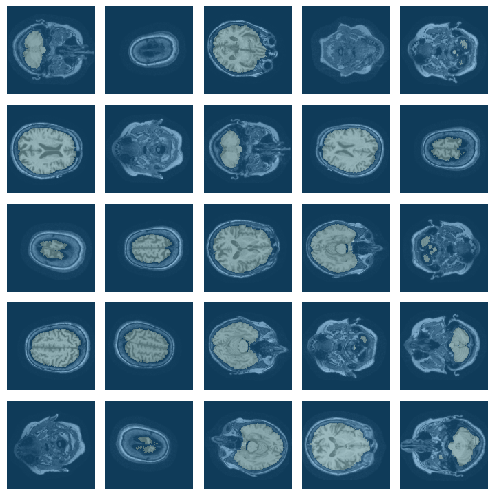

In [18]:
data.show_batch(5, figsize=(7,7))

In [19]:
# load a model
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)
learn.load('3.01_02_train-axial_bias_uf_foc-20_lr-1e3_sp-all');

### Predictions

In [20]:
%%time
pred = 0
if pred:
    #predykcje 
    pred = learn.get_preds()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


### Create an empty arrrays for results (fsl_128, pred_128, x_128)

In [21]:
%%time
create = 0
if create:
    # tworzymy macierze z obrazami
    n = len(learn.data.valid_dl.dataset.items)
    fsl_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    pred_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    x_128 = np.zeros((n, 128, 128), dtype=np.float32)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.5 µs


### Fill in arrays with 2D images

In [22]:
%%time
# Fill in fsl_128 and pred_128 with label and prediction
fillin = 0
if fillin:
    k = 0
    for k in range(n):
        x,y = learn.data.valid_ds[k]  
        p,_,_ = learn.predict(x)

        fsl_128[k,:,:] = np.squeeze(to_np(y))
        x_128[k,:,:] = np.squeeze(to_np(x))
        pred_128[k,:,:] = np.squeeze(to_np(p))  
        print(f'{k:06}/{n}', end='\r')
        k += 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [23]:
# nazwy plikow
#learn.data.valid_dl.dataset.items[0]

### Save predictinos to a disc

In [24]:
%%time
save1 = 0
if save1:  
    # create a df with all 2d filenames
    full_names = list(learn.data.valid_dl.items)
    # save matrix with predictions to npz file
    # save uncompressed 
    save_name = '3.01_uncompressed_results'
    save_pth = SAVE_PTH_301_DATA / save_name
    np.savez(save_pth, full_names=full_names, fsl_128=fsl_128, pred_128=pred_128, x_128=x_128)
    save_pht

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [25]:
%%time
save2 = 0 
if save2:
    # create a df with all 2d filenames
    full_names = list(learn.data.valid_dl.items)
    # save compressed 
    save_name = '3.01_compressed_results'
    save_pth = SAVE_PTH_301_DATA / save_name
    np.savez_compressed(save_pth, full_names=full_names, fsl_128=fsl_128, pred_128=pred_128, x_128=x_128)
    save_pht

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


___

### Load predictions from a matrix

In [26]:
%%time
load = 1
if load:
    save_name = '3.01_uncompressed_results.npz'
    save_pth = SAVE_PTH_301_DATA / save_name
    X = np.load(save_pth)
    
    full_names = X['full_names']
    fsl_128 = X['fsl_128']
    pred_128 = X['pred_128']
    x_128 = X['x_128']

CPU times: user 11.7 s, sys: 2.83 s, total: 14.5 s
Wall time: 14.5 s


### Prepare df with basic info and Dice and Jaccards coefs

Based on index obtained from df we can manipulate data from *fsl_128, pred_128, x_128*.

In [27]:
# create a df with all 2d filenames
full_names = list(learn.data.valid_dl.items)

df = pd.DataFrame.from_dict({'full':full_names, 'mask_full_path': df2.mask_full_path})
# common name part for each examination (without slice number e.g 001)
df['part'] = df.full.apply(lambda x: x[:-7])

# identify the database
for db in ['ADNI', 'AIBL', 'IXI', 'PPMI', 'SALD', 'SLIM', 'CalgaryCampinas']:
    df.loc[df.full.str.contains(db), 'exam'] = db 
    
save = 0
if save:
    save_name = '3.01_dice_jaccard.csv'
    save_pth = SAVE_PTH_301_CSV / save_name
    df.to_csv(save_pth, index=False)
    
    
print(df.shape)
df.head(2)

(158226, 4)


,full,mask_full_path,part,exam
0,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927...,ADNI
1,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927...,ADNI


#### TESTS

In [47]:
tests = 0
if tests:
    # Get names from df; identify db's in a test set
    print(f50.get_db_names(df))
    
    # Get one db from the entire test set
    dfn, idx = f50.get_single_db(df,'PPMI')
    
    # get patients name from a full df or a choosen DB
    pat = f50.get_all_patient_list_from_df(dfn)
    print(len(pat))
    
    pt = pat[0]
    dfp, idxp = f50.get_one_patient(dfn, pt)
    print(idxp)

### Dice & Jaccard

In [29]:
%%time

# CALCULATE DICE AND JACCARD AND UPDATE A DF
calculate_dice = 1

if calculate_dice:
    dice = []
    jaccard = []

    for k in range(len(fsl_128)):
        d,j = f50.dice_jaccard(fsl_128[k,:,:], pred_128[k,:,:])
        dice.append(d)
        jaccard.append(j)
        
    df['dice'] = dice
    df['jaccard'] = jaccard
    
    save_name = '3.01_dice_jaccard.csv'
    save_pth = SAVE_PTH_301_CSV / save_name
    df.to_csv(save_pth, index=False)

CPU times: user 8.45 s, sys: 104 ms, total: 8.56 s
Wall time: 8.62 s


### Mean Dice and Jaccard for all slices

Mean value of Dice  & Jaccard counted for all slices, even for those with coefficients equalled to zero

In [30]:
d_mean_all = df.dice.mean()
j_mean_all = df.jaccard.mean()
print(f'Dice mean for all slices: {d_mean_all:.3f}')
print(f'Jaccard mean for all slices: {j_mean_all:.3f}')

Dice mean for all slices: 0.568
Jaccard mean for all slices: 0.542


### Mean Dice and Jaccard for slices without zero values

In [31]:
df_j = df[df['jaccard'] != -1]
#print(df.shape,df_j.shape, df.shape[0]-df_j.shape[0])
df_d = df[df['dice'] != -1]
#print(df.shape, df_d.shape, df.shape[0]-df_d.shape[0])

d_mean_not_zero = df_d.dice.mean()
j_mean_not_zero = df_j.jaccard.mean()
print(f'Dice mean for all slices: {d_mean_not_zero:.3f}')
print(f'Jaccard mean for all slices: {j_mean_not_zero:.3f}')

Dice mean for all slices: 0.931
Jaccard mean for all slices: 0.900


### Visualization

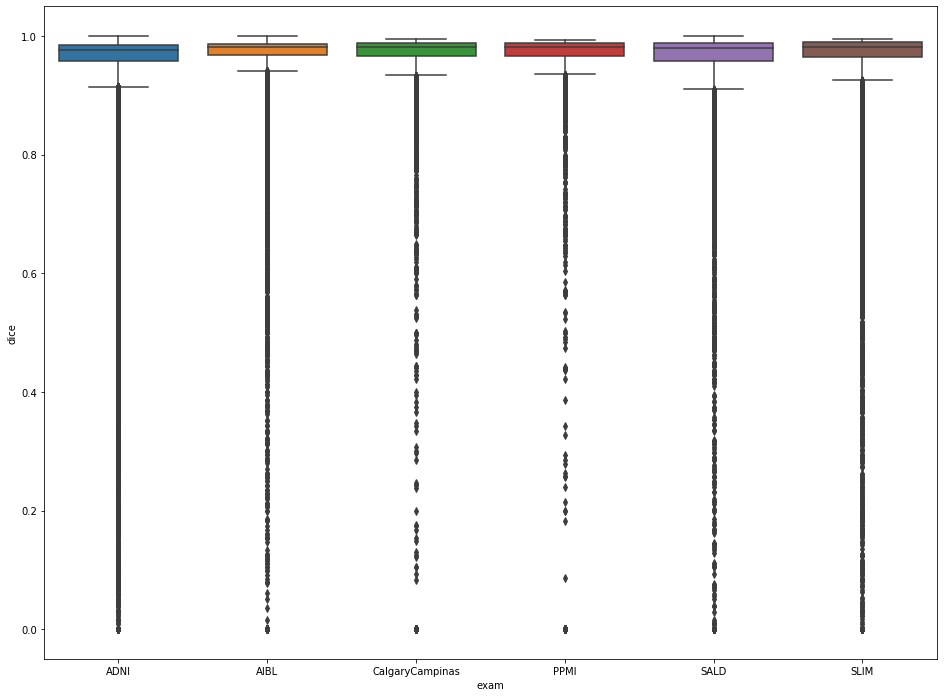

In [41]:

fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(ax=ax, x='exam', y='dice', data=df_j)

___

/data-10tb/shared/skull/axial-2d//test/AIBL/AIBL_1501_MPRAGE_ADNI_confirmed_2013-08-28_10_06_23.0_S235759_I450912.anat/T1_biascorr_iso_112.png
torch.Size([1, 192, 240]) <class 'fastai.vision.image.Image'>
torch.Size([1, 128, 128]) <class 'fastai.vision.image.Image'>
torch.Size([1, 128, 128]) <class 'fastai.vision.image.ImageSegment'>


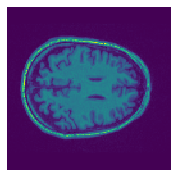

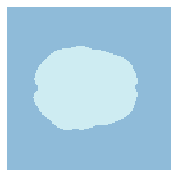

In [116]:
k = 105001
x,y = learn.data.valid_ds[k]
print(learn.data.valid_dl.dataset.items[k])
x.show()

img = open_image(learn.data.valid_dl.dataset.items[k], convert_mode='L')
print(img.shape, type(img))
prediction = learn.predict(img)[0]
print(x.shape, type(x))
print(prediction.shape, type(prediction))
prediction.show()

___

In [119]:
def draw(x, pred):
    f,ax = plt.subplots(1,5,figsize=(20,8))
    
    p0, p1, p2 = pred
    cm = 'hot'
    ax[0].imshow(np.squeeze(x.data), cmap=cm)
    ax[0].set_title('image')
    
    p0 = pred[0].data.numpy()
    ax[1].imshow(p0[0,...], cmap=cm)
    ax[1].set_title('predicted class')

    p1 = pred[1].data.numpy()
    ax[2].imshow(p1[0,...], cmap=cm)
    ax[2].set_title('labels')

    p2 = pred[2].data.numpy()
    ax[3].imshow(p2[0,...], cmap=cm)
    ax[3].set_title('ptobabilities of background')
    
    p3 = pred[2].data.numpy()
    ax[4].imshow(p2[1,...], cmap=cm)
    ax[4].set_title('ptobabilities of brain')    
     
    plt.tight_layout()
    f.show()

/data-10tb/shared/skull/axial-2d//test/AIBL/AIBL_1501_MPRAGE_ADNI_confirmed_2013-08-28_10_06_23.0_S235759_I450912.anat/T1_biascorr_iso_112.png


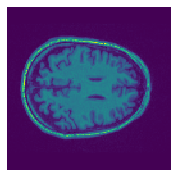

In [120]:
k = 105001
print(learn.data.valid_dl.dataset.items[k])
x,y = learn.data.valid_ds[k]
x.show()

In [121]:
pred = learn.predict(x)
p = pred[0].data

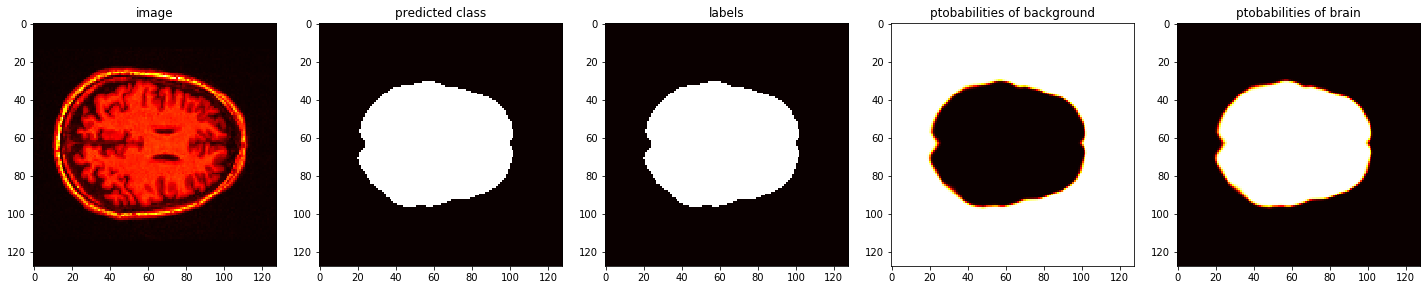

In [123]:
draw(x, pred)

In [111]:
def vis_template(y, x, p):
    plt.figure(figsize=(20,12))
    plt.subplot(131)
    plt.imshow(to_np(np.squeeze(y.data)))
    plt.title('FSL')

    plt.subplot(132)
    plt.imshow(np.squeeze(to_np(x)))
    plt.title('image')

    plt.subplot(133)
    plt.imshow(np.squeeze(p))
    plt.title('predykcja')

___

In [144]:
def vis1(y, x, p, cmap='gray', tit=['FSL', 'Image', 'Prediction']):
    plt.figure(figsize=(20,12))
    plt.subplot(131)
    plt.imshow(y, cmap=cmap)
    plt.title(tit[0])
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(x, cmap=cmap)
    plt.title(tit[1])
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(p, cmap=cmap)
    plt.title(tit[2])
    plt.axis('off')
    plt.tight_layout()

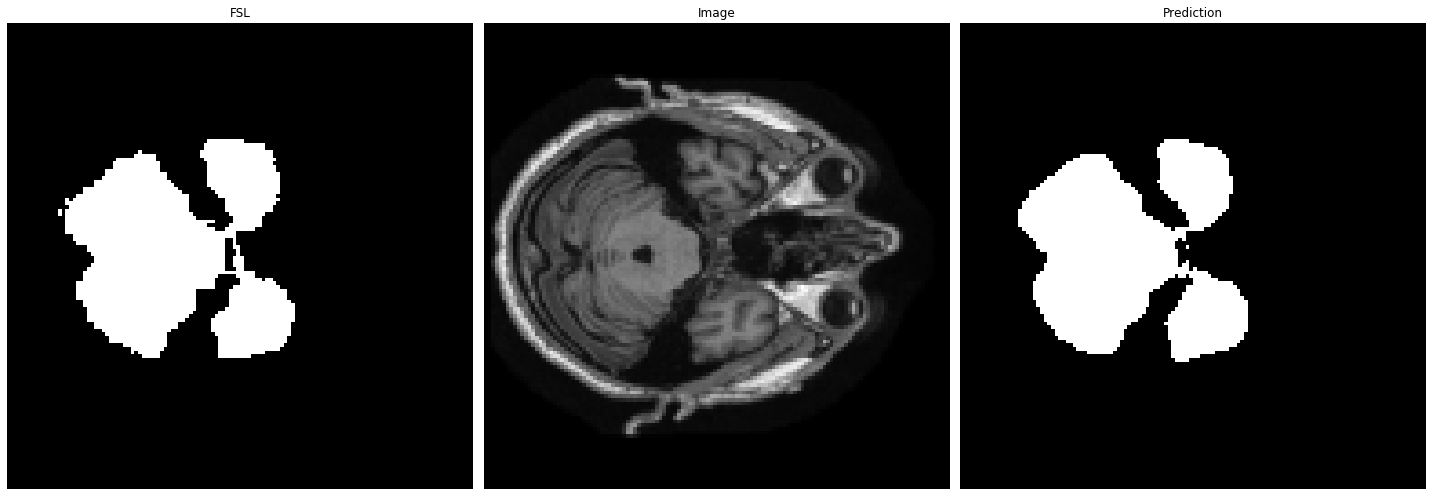

In [145]:
k = 50
vis1(fsl_128[k], x_128[k], pred_128[k])

___

In [212]:
def vis2(y, x, p, cmap='Reds', tit=['FSL', 'Image', 'Prediction'], alpha=0.5):
    
    rgb1 = gray2rgb(x, True)
    xx1,yy1 = np.where(y==1)
    rgb1[xx1,yy1,0] = 1
    
    rgb2 = gray2rgb(x, True)
    xx2,yy2 = np.where(p==1)
    rgb2[xx2,yy2,0] = 1
    
    plt.figure(figsize=(20,12))
    plt.subplot(121)
    plt.imshow(rgb1)
    plt.title(tit[0])
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(rgb2)
    plt.title(tit[1])
    plt.axis('off')
    plt.tight_layout()

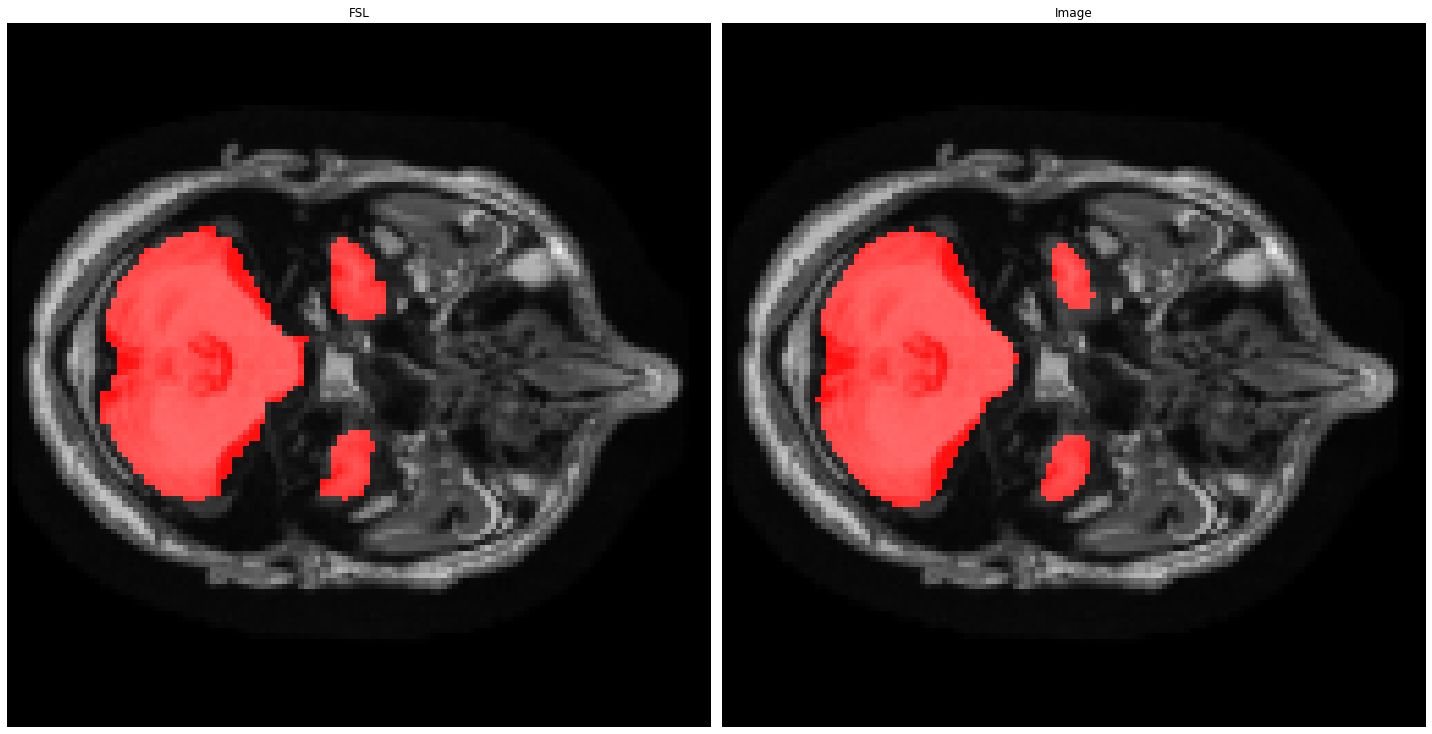

In [216]:
k = 1050
vis2(fsl_128[k], x_128[k], pred_128[k])

___

In [95]:
# one patient (P) indices, acquired above

xP = x_128[idxp]
yP = fsl_128[idxp]
pP = pred_128[idxp]

In [93]:
def vis3(y, x, p, k= 50, cmap='gray', tit=['FSL', 'Image', 'Prediction']):
    """
    Visiualization from 3D image (single examination)
    """
    plt.figure(figsize=(20,12))
    plt.subplot(131)
    plt.imshow(y[k,:,:], cmap=cmap)
    plt.title(tit[0])
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(x[k,:,:], cmap=cmap)
    plt.title(tit[1])
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(p[k,:,:], cmap=cmap)
    plt.title(tit[2])
    plt.axis('off')
    plt.tight_layout()

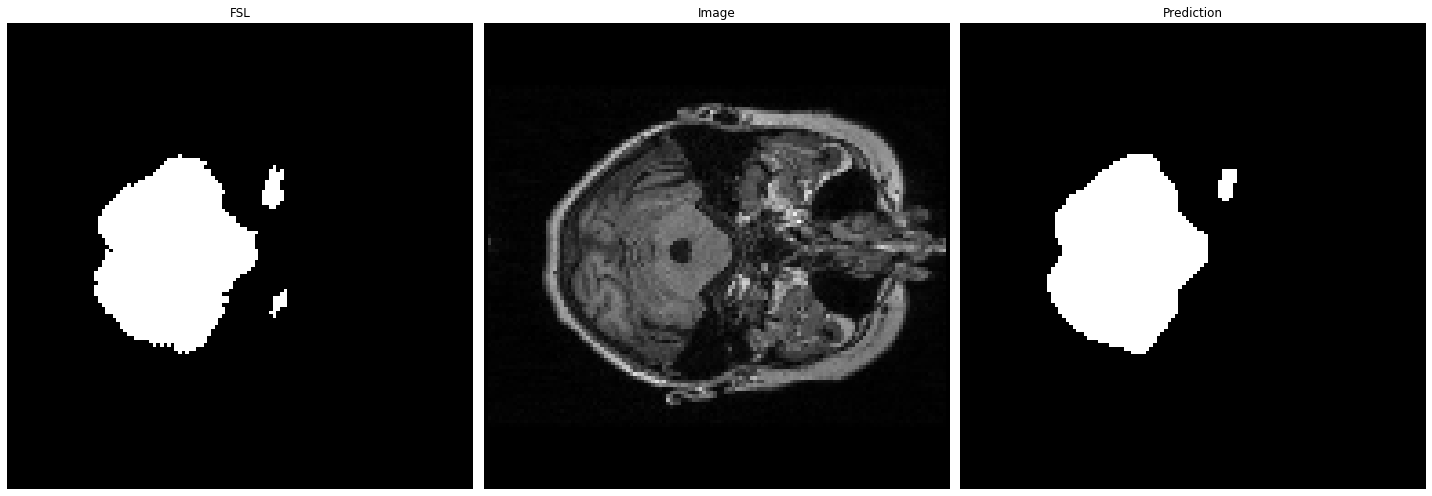

In [94]:
vis3(yP,xP,pP)

___

In [84]:
import nibabel as nib

In [97]:
# from previus lines, from TEST;
pt

'/data-10tb/shared/skull/axial-2d//test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_iso_'

In [114]:
cur_df, cur_idx = f50.get_one_patient(df, pt)
cur_df.head(2)

,full,mask_full_path,part,exam,dice,jaccard
113729,/data-10tb/shared/skull/axial-2d//test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_iso_000.png,/data-10tb/shared/skull/axial-2d/test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_brain_mask_iso_nn_000.png,/data-10tb/shared/skull/axial-2d//test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_iso_,PPMI,-1.0,-1.0
113730,/data-10tb/shared/skull/axial-2d//test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_iso_001.png,/data-10tb/shared/skull/axial-2d/test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_brain_mask_iso_nn_001.png,/data-10tb/shared/skull/axial-2d//test/PPMI/PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat/T1_biascorr_iso_,PPMI,-1.0,-1.0


In [179]:
def save_as_nifti(patient_pattern, image, test_name, save_name ):
    exam_name = patient_pattern.split('/')[-2]
    print(exam_name)
    print(test_name)
    df_masks = pd.read_csv(test_name)
    df_masks.head()
    cur_msk_3d = df_masks[df_masks['mask_nn_pth_titan'].str.contains(new_name)]
    cur_mask = cur_msk_3d.mask_nn_pth_titan

    nii = nib.load(cur_mask.values[0])
    hdr =  nii.header

    hdr['descrip'] = 'MMIV/ML-nib: ' + nib.__version__ + '-by MK ({})'.format(time.strftime("%Y-%m-%d"))
    img = nib.Nifti1Image(image, affine=np.eye(4), header=hdr)
    img.set_data_dtype(image.dtype.name)
    img.to_filename(save_name)

In [180]:
patient_pattern = pt
test_name = TEST_3D
save_name = 'xxxx'
image = xP
save_as_nifti(pt, xP, TEST_3D, 'zzzz.nii.gz')

PPMI_3114_MR_T1-anatomical_Br_20120905120705829_S120901_I330555.anat
/data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv


___

#### Nilearn

In [49]:
#from nilearn import plotting
#plotting.view_img(xP, bg_img=yP, threshold=None, opacity=0.5)

____

#### itkwidgets

In [64]:
#from itkwidgets import view, compare
#view(xP,label_image=pP, label_image_blend=0.7, slicing_planes=False, mode='x')
#compare(pP, pP, link_cmap=True)

___